# Text Classification Using CNN - Extension

## NOTE:
- Since we are using NLTK here, it would be advisable to download ALL NLTK corpora/samples
- This code uses the **Low-Level Symbol API** - the code therefore tends to be messy
- Default models (in part 1):
    - Do not include dropout layers
    - Do not do learning rate decay
- This code is adapted and extended from [MXNet's Tutorial](https://mxnet.incubator.apache.org/versions/master/tutorials/nlp/cnn.html)

In [1]:
# these are the modules you are allowed to work with. 

import nltk
from nltk import word_tokenize
import re
import numpy as np
import mxnet as mx
import sys, os

### Pre-processing functions

In [2]:
'''
First job is to clean and preprocess the social media text. (5)

1) Replacing URLs by  "_URL_" and mentions (i.e strings which are preceeded with @) by "_MENT_"
2) Segment #hastags 
3) Remove emoticons and other unicode characters
'''

def preprocess_tweet(string):
    '''
    Input: The input string read directly from the file
    
    Output: Pre-processed tweet text
    '''
    string = re.sub(r"((http:\/\/)?www\.|(https:\/\/)?www\.|http:\/\/|https:\/\/)+[^\s]+", "_URL_", string) #replacing URLs
    string = re.sub(r"(@)+[^\s]+", "_MENT_", string) #replacing Mentions
    #search with hash-tags
    hash_tag_p = re.compile(r"(#)+[^\s]+")
    matches={}
    for x in re.finditer(hash_tag_p,string):
        tag=x.group()
        new_tag=tag.strip('#')
        new_tag=" ".join([match.group() for match in re.finditer("[A-Z][a-z]*[^(A-Z)]",new_tag)])
        string=string.replace(tag,new_tag)
    #removing emoticons
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
                           "]+", flags=re.UNICODE)
    emoji_pattern.sub("",string)
    #removing unicode characters
    string = string.encode('ascii', 'ignore').decode("utf-8")    
    
    string = re.sub(r"[^A-Za-z]", " ", string) #removing punctuations & numerical values
    string = string.strip().lower()
    return string


# reading the input file and separating the set of positive examples and negative examples. 

file=open('cancer_data.tsv','r')
pos_data=[]
neg_data=[]

for line in file:
    line = line.strip().split('\t')
    text2 = preprocess_tweet(line[0]).strip().split()
    if line[1] == 'yes':
        pos_data.append(text2)
    if line[1] == 'no':
        neg_data.append(text2)

print(len(pos_data), len(neg_data))     

sentences= list(pos_data)
sentences.extend(neg_data)
pos_labels= [1 for _ in pos_data]
neg_labels= [0 for _ in neg_data]
y=list(pos_labels)
y.extend(neg_labels)
y=np.array(y)

208 1298


***
**After this we obtain the following :**

1. sentences =  List of sentences having the positive and negative examples with all the positive examples first
2. y = List of labels with the positive labels first.

Before running the CNN there are a few things one needs to take care of: (5)

1. Pad the sentences so that all of them are of the same length
2. Build a vocabulary comprising all unique words that occur in the corpus
3. Convert each sentence into a corresponding vector by replacing each word in the sentence with the index in the vocabulary. 

Example :
S1 = a b a c
S2 = d c a 

Step 1:  S1= a b a c, 
         S2 =d c a </s> 
         (Both sentences are of equal length). 

Step 2:  voc={a:1, b:2, c:3, d:4, </s>: 5}

Step 3:  S1= [1,2,1,3]
         S2= [4,3,1,5]

In [3]:
def pad_sentences(sentences, padding_word="</s>"):
    """
    Pads all sentences to be the length of the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)

    #still, a list of strings(each string is a "sentence")
    return padded_sentences



def build_vocab(sentences):
    """
    Builds a vocabulary mapping from token to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    tokens=[]
    # Mapping from index to word
    for sent in sentences:
        tokens.extend(sent)
    token_counts_dict={}
    for word in tokens:
        if word not in token_counts_dict:
            token_counts_dict[word]=tokens.count(word)
        else:
            continue
    
    vocabulary_inv=[]
    
    #iterates in decreasing order by keys
    for k,v in token_counts_dict.items():
        vocabulary_inv.append(k)
        
    # Mapping from word to index
    vocabulary = {vocabulary_inv[i]: i for i in range(len(vocabulary_inv))}
    
    return vocabulary, vocabulary_inv


def create_word_vectors(sentences):
    '''
    Input: List of sentences
    Output: List of word vectors corresponding to each sentence, vocabulary
    '''
    sentences=pad_sentences(sentences)
    vocab,inv_vocab=build_vocab(sentences)
    sent_vectors = np.array([
            [vocab[word] for word in sentence]
            for sentence in sentences])
    return sent_vectors, vocab


def create_shuffle(x,y):
    '''
    Create an equal distribution of the positive and negative examples. 
    Please do not change this particular shuffling method.
    '''
    pos_len= len(pos_data)
    neg_len= len(neg_data)
    # ensuring proper mix of +ve & -ve samples
    pos_len_train= int(0.8*pos_len)
    neg_len_train= int(0.8*neg_len)
    train_data= [(x[i],y[i]) for i in range(0, pos_len_train)]
    train_data.extend([(x[i],y[i]) for i in range(pos_len, pos_len+ neg_len_train )])
    test_data=[(x[i],y[i]) for i in range(pos_len_train, pos_len)]
    test_data.extend([(x[i],y[i]) for i in range(pos_len+ neg_len_train, len(x) )])

    np.random.shuffle(train_data)
    x_train=[i[0] for i in train_data]
    y_train=[i[1] for i in train_data]
    np.random.shuffle(test_data)
    x_test=[i[0] for i in test_data]
    y_test=[i[1] for i in test_data]
    
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test= np.array(x_test)
    y_test= np.array(y_test)
    return x_train, y_train, x_test, y_test
# obtaining the data
x,vocab=create_word_vectors(sentences)
x_train, y_train, x_test, y_test= create_shuffle(x,y)

In [4]:
# default parameters
n_epochs=10
batch_size=20
size_embed=200
num_filter=100
vocab_size=len(vocab)
sentence_len=x_train.shape[1]
filters=[2,3,4,5]
learn_rate=0.005
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}


***

### Declaring and visualizing the graph

In [5]:
#placeholders
input_x = mx.sym.Variable('data')
input_y = mx.sym.Variable('softmax_label')
print ("input shape: ",x_train.shape)

#embeddings layer - for converting to n-dimension vector representations while training
embed = mx.sym.Embedding(data=input_x, input_dim=vocab_size, output_dim=size_embed, name='embed_layer')
#inferring shape of the output:
embed_op_shape=embed.infer_shape(data=x_train.shape)[1]
print("Shape of embed layer o/p: ",embed_op_shape)

#reshaping for further layers:
conv_input = mx.sym.Reshape(data=embed, shape=(batch_size, 1, sentence_len, size_embed))

#conv layers: sizes:2,3,4,5 - bi-,tri-, 4-, 5- grams considered - creating multiple PARALLEL convolutional layers... 
# ...  - to be later combined
pooled_outputs = []
for filter_size in filters:
    convi = mx.sym.Convolution(data=conv_input, kernel=(filter_size, size_embed), num_filter=num_filter)
    relui = mx.sym.Activation(data=convi, act_type='relu')
    pooli = mx.sym.Pooling(data=relui, pool_type='max', kernel=(sentence_len - filter_size + 1, 1), stride=(1, 1))
    pooled_outputs.append(pooli)

# combining pooled outputs
total_filters = num_filter * len(filters)
concat = mx.sym.Concat(*pooled_outputs, dim=1)  # ('*' unpacks the list)

# reshaping for next layer
h_pool = mx.sym.Reshape(data=concat, shape=(batch_size, total_filters))

# fully connected layer
cls_weight = mx.sym.Variable('cls_weight')
cls_bias = mx.sym.Variable('cls_bias')

fc = mx.sym.FullyConnected(data=h_pool, weight=cls_weight, bias=cls_bias, num_hidden=2)

# softmax output
sm = mx.sym.SoftmaxOutput(data=fc, label=input_y, name='softmax')
cnn = sm

input shape:  (1204, 112)
Shape of embed layer o/p:  [(1204, 112, 200)]


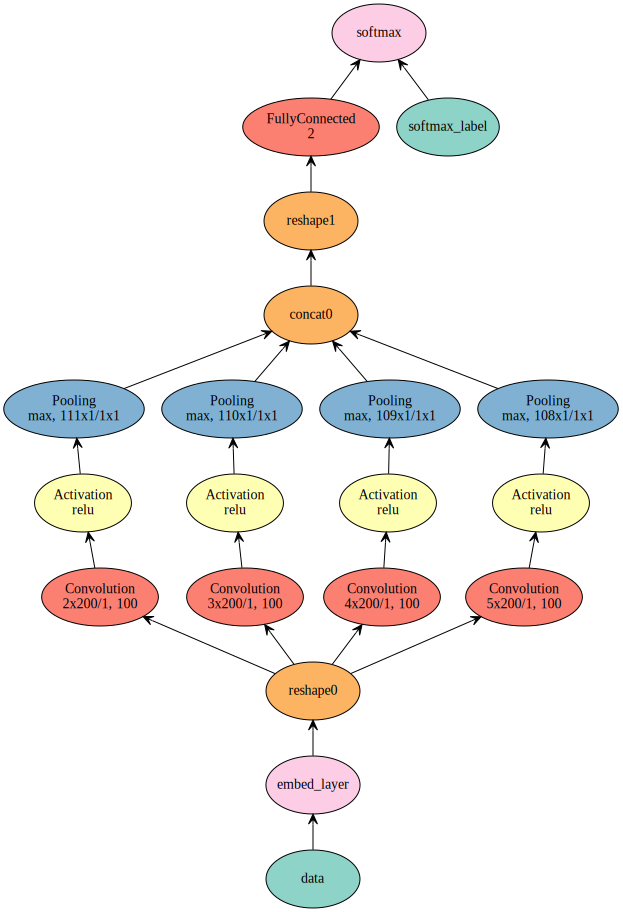

In [6]:
mx.viz.plot_network(cnn, node_attrs={"shape":"oval","fixedsize":"false"})


***

### Declaring the custom Training Function

In [7]:
def train_fn(symbol,ctx,
             x_train,x_test,y_train,y_test,
             optimizer='rmsprop',max_grad_norm=2.0,display_step=1):
    '''
    Custom training function:
    Params:
        symbol : outermost layer of the network
        x_train,y_train: training data
        x_test, y_test: test data
        
    Returns:
        train_accs: the train accuracies obtained for EACH BATCH (numpy array: n_epochs)
        test_accs: the test accuracies obtained for EACH BATCH (numpy array: n_epochs)
        train_preds: the predictions on the training data for EACH BATCH (numpy array: n_epochs X n_samples)
        test_preds: the predictions on the test data for EACH BATCH (numpy array: n_epochs X n_samples)
        
    (Prints the status of training and test metrics)
    '''
    ##################################################################
    test_accs=np.zeros(n_epochs)
    train_accs=np.zeros(n_epochs)
    train_preds=np.zeros((n_epochs,x_train.shape[0]))
    test_preds=np.zeros((n_epochs,x_test.shape[0]))
    
    arg_names = symbol.list_arguments()
    input_shapes = {}
    input_shapes['data'] = (batch_size,)+x_train.shape[1:]
    arg_shape, out_shape, aux_shape = symbol.infer_shape(**input_shapes)
    
    # declaring all weights/biases
    arg_arrays = [mx.nd.zeros(s, ctx) for s in arg_shape]
    
    # gradients dictionary - declaring all gradients
    args_grad = {}
    for shape, name in zip(arg_shape, arg_names):
        if name in ['softmax_label', 'data']: # input, output
            continue
        args_grad[name] = mx.nd.zeros(shape, ctx)

    # binding the executor
    cnn_exec = symbol.bind(ctx=ctx, args=arg_arrays, args_grad=args_grad, grad_req='add')
    param_blocks = []
    arg_dict = dict(zip(arg_names, cnn_exec.arg_arrays))
    
    #initializing - Uniform initialization of all variables
    initializer = mx.initializer.Uniform(0.01)
    for i, name in enumerate(arg_names):
        if name in ['softmax_label', 'data']: # leave aside input, output
            continue
        initializer(mx.init.InitDesc(name), arg_dict[name])

        param_blocks.append( (i, arg_dict[name], args_grad[name], name) )
    
    
    
    #################################################################
    # creating and setting-up optimizer, updater
    opt = mx.optimizer.create(optimizer)
    opt.lr = learn_rate
    updater = mx.optimizer.get_updater(opt)

    # For each training epoch
    for iteration in range(n_epochs):
        num_correct = 0
        num_total = 0

        # Over each batch of training data
        for begin in range(0, x_train.shape[0], batch_size):
            batchX = x_train[begin:begin+batch_size]
            batchY = y_train[begin:begin+batch_size]
            if batchX.shape[0] != batch_size:
                continue

            cnn_exec.arg_dict['data'][:] = batchX
            cnn_exec.arg_dict['softmax_label'][:] = batchY

            # forward pass
            cnn_exec.forward(is_train=True)

            # backward pass - computes gradients
            cnn_exec.backward()

            # generated outputs from forward pass accessible through cnn_exec.outputs
            # eval on training data
            train_preds[iteration,begin:begin+batch_size]=np.argmax(cnn_exec.outputs[0].asnumpy(), axis=1)
            num_correct += sum(batchY == np.argmax(cnn_exec.outputs[0].asnumpy(), axis=1))
            num_total += len(batchY)

            # updating weights
            # the args_grad list contains the gradients and is bound to the executor...
            # ... it, therefore gives access to the generated gradients
            norm = 0
            for idx, weight, grad, name in param_blocks:
                grad /= batch_size
                l2_norm = mx.nd.norm(grad).asscalar()
                norm += l2_norm * l2_norm

            norm = np.sqrt(norm)
            for idx, weight, grad, name in param_blocks:
                if norm > max_grad_norm:
                    grad *= (max_grad_norm / norm)

                updater(idx, grad, weight)

                # resetting gradients to zero
                grad[:] = 0.0

        # End of training loop for this epoch
        train_acc = num_correct * 100 / float(num_total)
    
        # Evaluate model after this epoch on dev (test) set
        num_correct = 0
        num_total = 0

        # For each test batch
        for begin in range(0, x_test.shape[0], batch_size):
            batchX = x_test[begin:begin+batch_size]
            batchY = y_test[begin:begin+batch_size]

            if batchX.shape[0] != batch_size:
                continue

            cnn_exec.arg_dict['data'][:] = batchX
            cnn_exec.forward(is_train=False)
            test_preds[iteration,begin:begin+batch_size]=np.argmax(cnn_exec.outputs[0].asnumpy(), axis=1)
            num_correct += sum(batchY == np.argmax(cnn_exec.outputs[0].asnumpy(), axis=1))
            num_total += len(batchY)

        test_acc = num_correct * 100 / float(num_total)
        test_accs[iteration]=test_acc
        train_accs[iteration]=train_acc
        if (iteration%display_step)==0:
            print('Iter [%d] Train: Training Accuracy: %.3f \
                    --- Test Accuracy : %.3f' % (iteration, train_acc, test_acc))
    return train_accs,test_accs,train_preds,test_preds

### Training the Model now

In [8]:
#the context - CPU used here
ctx = mx.cpu()
train_accs,test_accs,train_preds,test_preds = train_fn(cnn,ctx,x_train,x_test,y_train,y_test)

Iter [0] Train: Training Accuracy: 86.167                     --- Test Accuracy : 85.667
Iter [1] Train: Training Accuracy: 90.417                     --- Test Accuracy : 84.000
Iter [2] Train: Training Accuracy: 94.833                     --- Test Accuracy : 89.333
Iter [3] Train: Training Accuracy: 97.917                     --- Test Accuracy : 89.667
Iter [4] Train: Training Accuracy: 99.167                     --- Test Accuracy : 90.000
Iter [5] Train: Training Accuracy: 99.500                     --- Test Accuracy : 90.667
Iter [6] Train: Training Accuracy: 99.667                     --- Test Accuracy : 90.000
Iter [7] Train: Training Accuracy: 99.667                     --- Test Accuracy : 89.667
Iter [8] Train: Training Accuracy: 99.667                     --- Test Accuracy : 90.667
Iter [9] Train: Training Accuracy: 99.750                     --- Test Accuracy : 89.333


## Extending the Process for Further Experimentation:

### Experimenting by introducing FastText model

In [9]:
#using Gensim for FastText embeddings creation and usage
from gensim.models import FastText
ft_model = FastText(size=size_embed, window=3, min_count=1)  # instantiating FastText model
#padded_sentences=pad_sentences(sentences)
corpus=sentences
ft_model.build_vocab(sentences=corpus)
ft_model.train(sentences=corpus, total_examples=len(corpus), epochs=20)

**Some nice examples proving that it did indeed learn something!!!**

In [10]:
ft_embeddings=ft_model.wv
print (ft_embeddings.doesnt_match("usa france ai politics".split()))
print(ft_embeddings.similar_by_word("fight"))

ai
[('fights', 0.9892082214355469), ('praise', 0.9811339378356934), ('fighters', 0.9776649475097656), ('funds', 0.9769025444984436), ('please', 0.9765199422836304), ('fish', 0.9749014377593994), ('needs', 0.9748384356498718), ('rainbow', 0.9742629528045654), ('five', 0.9740978479385376), ('finish', 0.9724087119102478)]


In [11]:
padded_sentences=pad_sentences(sentences)
new_sent_vectors = np.array([
            [ft_embeddings[word] if word!='</s>' else np.zeros(200) for word in sentence]
            for sentence in padded_sentences])
print(new_sent_vectors.shape)
#this value ought to be same as the output of the embedding layer of the previous model

(1506, 112, 200)


### Defining & Training the new model

In [12]:
new_x_train,new_y_train,new_x_test,new_y_test=create_shuffle(new_sent_vectors,y)


# NOTE: It is imperative, at this stage that we DO NOT change the names of the ...
#... the input and output placeholders, as the training function above uses them...
#... Otherwise, the content of the function could be copied directly and used.


# creating a CNN new model - almost same as before - without the embeddings layer
new_input_x = mx.sym.Variable('data')
new_input_y = mx.sym.Variable('softmax_label')
new_conv_input = mx.sym.Reshape(data=new_input_x, shape=(batch_size, 1, sentence_len, size_embed))
new_pooled_outputs = []
for filter_size in filters:
    new_convi = mx.sym.Convolution(data=new_conv_input, kernel=(filter_size, size_embed), num_filter=num_filter)
    new_relui = mx.sym.Activation(data=new_convi, act_type='relu')
    new_pooli = mx.sym.Pooling(data=new_relui, pool_type='max', kernel=(sentence_len - filter_size + 1, 1), stride=(1, 1))
    new_pooled_outputs.append(new_pooli)

total_filters = num_filter * len(filters)
new_concat = mx.sym.Concat(*new_pooled_outputs, dim=1)  # ('*' unpacks the list)

new_h_pool = mx.sym.Reshape(data=new_concat, shape=(batch_size, total_filters))

# fully connected layer
new_cls_weight = mx.sym.Variable('cls_weight')
new_cls_bias = mx.sym.Variable('cls_bias')

new_fc = mx.sym.FullyConnected(data=new_h_pool, weight=new_cls_weight, bias=new_cls_bias, num_hidden=2)

# softmax output
new_sm = mx.sym.SoftmaxOutput(data=new_fc, label=new_input_y, name='softmax')
new_cnn = new_sm

# calling the custom training function
ctx=mx.cpu()
new_train_accs,new_test_accs,new_train_preds,new_test_preds = train_fn(new_cnn,ctx,new_x_train,new_x_test,new_y_train,new_y_test)

Iter [0] Train: Training Accuracy: 85.250                     --- Test Accuracy : 86.000
Iter [1] Train: Training Accuracy: 85.333                     --- Test Accuracy : 86.667
Iter [2] Train: Training Accuracy: 85.333                     --- Test Accuracy : 87.000
Iter [3] Train: Training Accuracy: 86.250                     --- Test Accuracy : 87.333
Iter [4] Train: Training Accuracy: 86.250                     --- Test Accuracy : 86.000
Iter [5] Train: Training Accuracy: 86.500                     --- Test Accuracy : 86.000
Iter [6] Train: Training Accuracy: 86.333                     --- Test Accuracy : 87.000
Iter [7] Train: Training Accuracy: 86.750                     --- Test Accuracy : 85.667
Iter [8] Train: Training Accuracy: 87.250                     --- Test Accuracy : 84.667
Iter [9] Train: Training Accuracy: 87.833                     --- Test Accuracy : 84.667


***
**Therefore, with the parameters unchanged, the introduction of the FastText embeddings to this model does not add to accuracies. Several reasons could be given for the observation:**
- Hyper-parameter tuning might change this
- The corpus on which embeddings have been trained is not vast enough to capture much context


***
### Alternative Metrics
- Accuracy is just the ratio of correct outcomes to all outcomes and hence is a poor indicator in this case because of data skew - a naive model throwing out just the result of the majority class could still achieve 6/7 = ~85% accuracy
- Precision and Recall are better indicators, especially since we know what class concerns here more (the +ve ones)
- Plotting the confusion matrix is a good way to visualize the distributions
- Since we have the predictions of the models after each epoch, we could directly use them

In [13]:
# function for calculating precision and recall
def prec_recall(y_true,y_pred,ref_class=1):
    '''
    params:
        y_true,y_pred = np array of same shape : different epochs along different rows
        ref_class = the class wrt which precision/recall is to be calculated
    return:
        prec
        recall
    '''
    tp=((y_pred==1)*(y_true==1)).sum(axis=1) #true positives
    fp=((y_pred==1)*(y_true==0)).sum(axis=1) #false positives
    tn=((y_pred==0)*(y_true==0)).sum(axis=1) #true negatives
    fn=((y_pred==0)*(y_true==1)).sum(axis=1) #false positive
    prec = np.nan_to_num(tp/(tp+fp))
    rec = np.nan_to_num(tp/(tp+fn))
    return prec,rec

In [14]:
p1_train,r1_train=prec_recall(y_train,train_preds)
p1_test,r1_test=prec_recall(y_test,test_preds)

p2_train,r2_train=prec_recall(new_y_train,new_train_preds)
p2_test,r2_test=prec_recall(new_y_test,new_test_preds)

In [15]:
print("Model 1(TRAIN): best precision of positive class = %.3f, best recall= %.3f" %(p1_train.max(),r1_train.max()))
print("Model 1(TEST): best precision of positive class = %.3f, best recall= %.3f" %(p1_test.max(),r1_test.max()))
print("Model 2(TRAIN): best precision of positive class = %.3f, best recall= %.3f" %(p2_train.max(),r2_train.max()))
print("Model 2(TEST): best precision of positive class = %.3f, best recall= %.3f" %(p2_test.max(),r2_test.max()))

Model 1(TRAIN): best precision of positive class = 0.988, best recall= 0.994
Model 1(TEST): best precision of positive class = 0.929, best recall= 0.548
Model 2(TRAIN): best precision of positive class = 0.604, best recall= 0.331
Model 2(TEST): best precision of positive class = 0.750, best recall= 0.357


**Clearly, FastText has not performed too well for the minority class.**

***
### Tinkering with the hyper-parameters
We could notice the following important points before going after the hyper-paramters:
- In real world application, the performance on the TEST data matters more
- Since it is much more important to capture all positive cases, even at the expense of some false positives (as while going through them manually, one could always leave them out. **We do not want to miss out the positive cases**. Therefore, **We must consider RECALL as the metric of choice**
- Model 2 (with FastText) appears to perform much worse compared to its potential. I'll therefore try to spend more effort on it.
- Model 1 has already achieved near-perfect performance on train data and improving performance in that case would involve some regularization, etc, for which the network will have to be edited

#### EXP-1: Smaller embeddings, more epochs on FastText model

In [16]:
n_epochs=50
batch_size=10
size_embed=100
learn_rate=0.002
ft_model = FastText(size=size_embed, window=3, min_count=1)  # instantiating FastText model
corpus=sentences
ft_model.build_vocab(sentences=corpus)
ft_model.train(sentences=corpus, total_examples=len(corpus), epochs=20)
ft_embeddings=ft_model.wv
new_sent_vectors = np.array([
            [ft_embeddings[word] if word!='</s>' else np.zeros(size_embed) for word in sentence]
            for sentence in padded_sentences])
new_x_train,new_y_train,new_x_test,new_y_test=create_shuffle(new_sent_vectors,y)
new_input_x = mx.sym.Variable('data')
new_input_y = mx.sym.Variable('softmax_label')
new_conv_input = mx.sym.Reshape(data=new_input_x, shape=(batch_size, 1, sentence_len, size_embed))
new_pooled_outputs = []
for filter_size in filters:
    new_convi = mx.sym.Convolution(data=new_conv_input, kernel=(filter_size, size_embed), num_filter=num_filter)
    new_relui = mx.sym.Activation(data=new_convi, act_type='relu')
    new_pooli = mx.sym.Pooling(data=new_relui, pool_type='max', kernel=(sentence_len - filter_size + 1, 1), stride=(1, 1))
    new_pooled_outputs.append(new_pooli)

total_filters = num_filter * len(filters)
new_concat = mx.sym.Concat(*new_pooled_outputs, dim=1)  # ('*' unpacks the list)

new_h_pool = mx.sym.Reshape(data=new_concat, shape=(batch_size, total_filters))
new_cls_weight = mx.sym.Variable('cls_weight')
new_cls_bias = mx.sym.Variable('cls_bias')

new_fc = mx.sym.FullyConnected(data=new_h_pool, weight=new_cls_weight, bias=new_cls_bias, num_hidden=2)
new_sm = mx.sym.SoftmaxOutput(data=new_fc, label=new_input_y, name='softmax')
new_cnn = new_sm
ctx=mx.cpu()
new_train_accs,new_test_accs,new_train_preds,new_test_preds = train_fn(new_cnn,ctx,new_x_train,new_x_test,new_y_train,new_y_test,display_step=5)
_,r=prec_recall(new_y_test,new_test_preds)
print("\n\nBest recall on test data: ",r.max())

Iter [0] Train: Training Accuracy: 86.167                     --- Test Accuracy : 86.000
Iter [5] Train: Training Accuracy: 87.250                     --- Test Accuracy : 84.667
Iter [10] Train: Training Accuracy: 89.833                     --- Test Accuracy : 81.333
Iter [15] Train: Training Accuracy: 93.667                     --- Test Accuracy : 79.333
Iter [20] Train: Training Accuracy: 95.667                     --- Test Accuracy : 85.667
Iter [25] Train: Training Accuracy: 96.833                     --- Test Accuracy : 86.333
Iter [30] Train: Training Accuracy: 98.167                     --- Test Accuracy : 83.333
Iter [35] Train: Training Accuracy: 98.583                     --- Test Accuracy : 81.667
Iter [40] Train: Training Accuracy: 98.167                     --- Test Accuracy : 76.333
Iter [45] Train: Training Accuracy: 99.083                     --- Test Accuracy : 83.333


Best recall on test data:  0.761904761905


**=> Much better recall at low learn_rate, small embedding size, large no. of epochs**
***

#### EXP-2: Dropouts in Model 1 + larger no. of epochs + higher number of filters : 2,3,4,5,6

In [17]:
n_epochs=50
batch_size=10
size_embed=100
learn_rate=0.002
dropout = 0.5
input_x = mx.sym.Variable('data')
input_y = mx.sym.Variable('softmax_label')
print ("input shape: ",x_train.shape)

#embeddings layer - for converting to n-dimension vector representations while training
embed = mx.sym.Embedding(data=input_x, input_dim=vocab_size, output_dim=size_embed, name='embed_layer')
#inferring shape of the output:
embed_op_shape=embed.infer_shape(data=x_train.shape)[1]
print("Shape of embed layer o/p: ",embed_op_shape)

#reshaping for further layers:
conv_input = mx.sym.Reshape(data=embed, shape=(batch_size, 1, sentence_len, size_embed))
filters=[2,3,4,5,6]
pooled_outputs = []
for filter_size in filters:
    convi = mx.sym.Convolution(data=conv_input, kernel=(filter_size, size_embed), num_filter=num_filter)
    relui = mx.sym.Activation(data=convi, act_type='relu')
    pooli = mx.sym.Pooling(data=relui, pool_type='max', kernel=(sentence_len - filter_size + 1, 1), stride=(1, 1))
    pooled_outputs.append(pooli)
total_filters = num_filter * len(filters)
concat = mx.sym.Concat(*pooled_outputs, dim=1)  # ('*' unpacks the list)
h_pool = mx.sym.Reshape(data=concat, shape=(batch_size, total_filters))
h_drop = mx.sym.Dropout(data=h_pool, p=dropout)
cls_weight = mx.sym.Variable('cls_weight')
cls_bias = mx.sym.Variable('cls_bias')
fc = mx.sym.FullyConnected(data=h_drop, weight=cls_weight, bias=cls_bias, num_hidden=2)
sm = mx.sym.SoftmaxOutput(data=fc, label=input_y, name='softmax')
cnn = sm
train_accs,test_accs,train_preds,test_preds = train_fn(cnn,ctx,x_train,x_test,y_train,y_test,display_step=5)
_,r=prec_recall(new_y_test,new_test_preds)
print("\n\nBest recall on test data: ",r.max())

input shape:  (1204, 112)
Shape of embed layer o/p:  [(1204, 112, 100)]
Iter [0] Train: Training Accuracy: 86.167                     --- Test Accuracy : 86.667
Iter [5] Train: Training Accuracy: 98.417                     --- Test Accuracy : 90.667
Iter [10] Train: Training Accuracy: 99.750                     --- Test Accuracy : 89.667
Iter [15] Train: Training Accuracy: 99.667                     --- Test Accuracy : 90.000
Iter [20] Train: Training Accuracy: 99.500                     --- Test Accuracy : 89.667
Iter [25] Train: Training Accuracy: 99.750                     --- Test Accuracy : 90.000
Iter [30] Train: Training Accuracy: 99.750                     --- Test Accuracy : 89.667
Iter [35] Train: Training Accuracy: 99.667                     --- Test Accuracy : 90.000
Iter [40] Train: Training Accuracy: 99.833                     --- Test Accuracy : 89.667
Iter [45] Train: Training Accuracy: 99.750                     --- Test Accuracy : 90.000


Best recall on test data:  0

***
# Conclusion

**Following were the outcomes of the experimentations:**
- Model 1 performs much better than the one with FastText with the given hyper-paramters
    - Model 1: Best Test Accuracy: 91%; Best Recall on Test data: 55%
    - Model 2: Best Test Accuracy: 87%; Best Recall on Test data: 36%
    
**Results of tuning hyper-parameters**
- Model 2, however shows marked improvement by:
    1. Reducing embedding size (lesser paramters to train)
    2. Lower learning rate and larger no. of epochs 
    3. The new performance: Best Test Accuracy: ~90%; Best Recall on Test data: 75%
    
    
- Model 1 was subjected to following new conditions:
    1. Dropouts introduced after convolutions (d=0.5)
    2. Low learning rate; larger number of epochs
    3. More filters: of sizes : 2,3,4,5,6 (100 each)
    4. Result: Significant improvement on test recall : ~75%